# EQUINE Image Classification Example

This notebook walks through a simple application of a Neural Network trained on a vision task -- predicting a clothing article in the FashionMNIST dataset -- as applied to image data from that and from regular MNIST, a handwritten digit dataset. In this, we load the datasets, train a model, wrap the model with two EQUINE architectures, and demonstrate out-of-distribution performance. 

This notebook requires some extra dependencies to run. You can uncomment the below cell to install them into your local environment.

In [1]:
#!pip install matplotlib, torchvision, scipy

In [2]:
import equine as eq

import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import scipy
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics.classification import MulticlassAccuracy 
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### 1. Load MNIST and FashionMNIST Datasets

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

X_train = training_data.data
Y_train = training_data.targets
X_train = X_train.type(torch.float32)
X_train = torch.unsqueeze(X_train, 1)

X_test = test_data.data
Y_test = test_data.targets
X_test = X_test.type(torch.float32)
X_test = torch.unsqueeze(X_test, 1)

trainloader = DataLoader(training_data,batch_size=64,shuffle=True, drop_last=True)
testloader = DataLoader(test_data,batch_size=64,shuffle=True, drop_last=True)

ood_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
X_ood = ood_data.data
X_ood = X_ood.type(torch.float32)
X_ood = torch.unsqueeze(X_ood, 1)

oodloader = DataLoader(ood_data,batch_size=64,shuffle=True, drop_last=True)

### 2. Create Embedding Model

We define a simple CNN using the LeNet architecture and our embedding model which allows freezing layers if weights are passed during initialization.

In [4]:
class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1   = torch.nn.Linear(16*5*5, 120)
        self.fc2   = torch.nn.Linear(120, 84)
        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        return torch.prod(torch.tensor(size))

class EmbeddingModel(LeNet):

    # passing in weights for a layer will freeze that layer
    # and it will not be updated during training
    def __init__(self, conv1_weights=None, conv2_weights=None, fc1_weights=None, 
                 fc2_weights=None, fc3_weights=None):
        super(EmbeddingModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, padding=2)
        if conv1_weights is not None:
            self.conv1.weight = conv1_weights
            self.conv1.weight.requires_grad = False
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        if conv2_weights is not None:
            self.conv2.weight = conv2_weights
            self.conv2.weight.requires_grad = False
        self.fc1 = torch.nn.Linear(16*5*5, 120)
        if conv1_weights is not None:
            self.fc1.weight = fc1_weights
            self.fc1.weight.requires_grad = False
        self.fc2 = torch.nn.Linear(120, 84)
        if fc2_weights is not None:
            self.fc2.weight = fc2_weights
            self.fc2.weight.requires_grad = False
        self.fc3 = torch.nn.Linear(84, 10)
        if fc3_weights is not None:
            self.fc3.weight = fc3_weights
            self.fc3.weight.requires_grad = False

We train the model for 30 epochs using SGD with two scheduled drops in learning rate.

In [5]:
model_orig = EmbeddingModel()
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(
        model_orig.parameters(),
        lr=0.01,
        momentum=0.9,
        weight_decay=0.0001,
    )
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[20,25], gamma=0.1)

train_accuracy = MulticlassAccuracy(10)
for epoch in range(30):
    epoch_loss = 0.0
    for i, (xs, labels) in enumerate(trainloader):
        opt.zero_grad()
        yhats = model_orig(xs)
        loss = loss_fn(yhats, labels)
        batch_acc = train_accuracy(yhats, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    #print(epoch_loss)
    total_train_accuracy = train_accuracy.compute()
    scheduler.step()

    print("Training acc for epoch {}: {:.3f}".format(epoch, total_train_accuracy))

Training acc for epoch 0: 0.659
Training acc for epoch 1: 0.747
Training acc for epoch 2: 0.786
Training acc for epoch 3: 0.808
Training acc for epoch 4: 0.824
Training acc for epoch 5: 0.835
Training acc for epoch 6: 0.844
Training acc for epoch 7: 0.852
Training acc for epoch 8: 0.858
Training acc for epoch 9: 0.863
Training acc for epoch 10: 0.868
Training acc for epoch 11: 0.872
Training acc for epoch 12: 0.875
Training acc for epoch 13: 0.879
Training acc for epoch 14: 0.882
Training acc for epoch 15: 0.885
Training acc for epoch 16: 0.887
Training acc for epoch 17: 0.890
Training acc for epoch 18: 0.892
Training acc for epoch 19: 0.894
Training acc for epoch 20: 0.897
Training acc for epoch 21: 0.900
Training acc for epoch 22: 0.902
Training acc for epoch 23: 0.905
Training acc for epoch 24: 0.907
Training acc for epoch 25: 0.909
Training acc for epoch 26: 0.911
Training acc for epoch 27: 0.913
Training acc for epoch 28: 0.915
Training acc for epoch 29: 0.916


To evaluate the model, we first consider its accuracy on the test dataset and then look at how well its predictive probabilities allow us to separate in-distribution data from out-of-distribution (OOD) data.  To do this, we compute the entropy of the predictive probability distribution.  Ideally, the model will produce predictions with low entropy for in distribution data and predictions with high entropy for out of distribution data.

Model accuracy on test set: 0.913


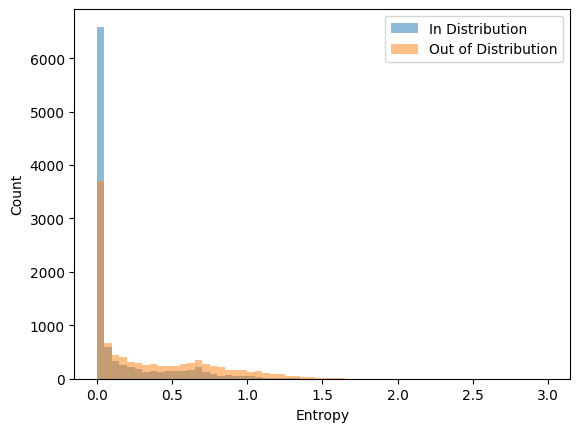

AUROC for detecting out of distribution examples: 0.696


In [6]:
model_orig.eval()

oods_in_dist = []
predictions = []
true_labels = []
for i, (xs, labels) in enumerate(testloader):
    y_pred = model_orig(xs).detach().numpy()
    oods = np.sum(scipy.special.entr(scipy.special.softmax(y_pred, axis=1)), axis=1)
    oods_in_dist.extend(list(oods))
    predictions.extend(list(np.argmax(y_pred, axis=1)))
    true_labels.extend(list(labels))
predictions = np.array(predictions)
true_labels = np.array(true_labels)
print('Model accuracy on test set: {:.3f}'.format(np.mean(predictions == true_labels)))
    
oods_out_dist = []
for i, (xs, labels) in enumerate(oodloader):
    y_pred = model_orig(xs).detach().numpy()
    oods = np.sum(scipy.special.entr(scipy.special.softmax(y_pred, axis=1)), axis=1)
    oods_out_dist.extend(list(oods))
    
plt.hist(oods_in_dist,bins=np.linspace(0,3,61),alpha=0.5, label='In Distribution')
plt.hist(oods_out_dist,bins=np.linspace(0,3,61),alpha=0.5, label='Out of Distribution')
plt.xlabel('Entropy')
plt.ylabel('Count')
plt.legend()
plt.show()
roc = roc_auc_score(np.hstack((np.ones_like(oods_out_dist),np.zeros_like(oods_in_dist))),
              oods_out_dist+oods_in_dist)
print('AUROC for detecting out of distribution examples: {:.3f}'.format(roc))

While the original model performs well on the in-distribution test data, its predictive probabilities do not allow us to discriminate between in-distribution and out-of-distribution data.  For example, the model confidently predicts below that the digit 7 belongs to one of the Fashion MNIST labels.

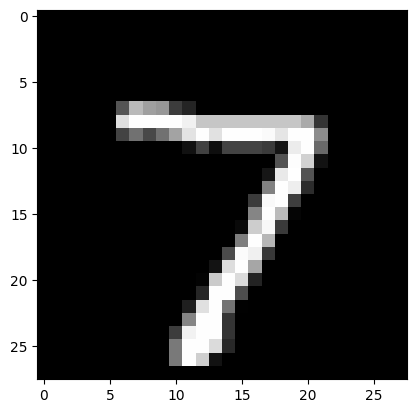

Predictive probabilities:
[[0.0000000e+00 0.0000000e+00 1.6196379e-26 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]


In [7]:
plt.imshow(X_ood[0:1].reshape(28,28), cmap="gray")
plt.show()
print('Predictive probabilities:')
print(scipy.special.softmax(model_orig(X_ood[0:1]).detach().numpy(), axis=1))

Seeing the limitations of the original model, we will now freeze all but the output layer and wrap the model with two different equine models.

### 3. Wrap embedding model with EquineGP

We first create a new EmbeddingModel, passing in the weights for the first four layers that we learned above.  We then wrap that EmbeddingModel in EquineGP.  The resulting model has an extra Gaussian Process "layer" on top of the original model.

In [8]:
model_GP = eq.EquineGP(EmbeddingModel(model_orig.conv1.weight, 
                                   model_orig.conv2.weight, 
                                   model_orig.fc1.weight, 
                                   model_orig.fc2.weight), 
                      emb_out_dim=10, num_classes = 10,
                      label_names=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"] )

We now train for a few more epochs to fine tune the last layer of the original model and learn the parameters in the Gaussian Process layer.

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
        model_GP.model.parameters(),
        lr=0.001,
        momentum=0.9,
        weight_decay=0.0,
    )
res_GP = model_GP.train_model(TensorDataset(X_train, Y_train), loss_fn, optimizer, 5, vis_support=True)

100%|████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.52s/it]


We now compute the test accuracy and out of distribution results to compare with the original model.

Model accuracy on test set: 0.885


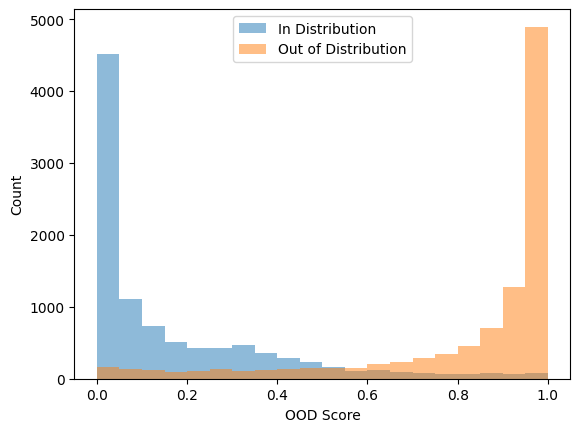

AUROC for detecting out of distribution examples: 0.948


In [10]:
oods_in_dist = []
predictions = []
true_labels = []
for i, (xs, labels) in enumerate(testloader):
    y_pred = model_GP.predict(xs)
    classes = y_pred.classes.detach().numpy()
    oods = y_pred.ood_scores.detach().numpy()
    oods_in_dist.extend(list(oods))
    predictions.extend(list(np.argmax(classes, axis=1)))
    true_labels.extend(list(labels))
predictions = np.array(predictions)
true_labels = np.array(true_labels)
print('Model accuracy on test set: {:.3f}'.format(np.mean(predictions == true_labels)))
    
oods_out_dist = []
for i, (xs, labels) in enumerate(oodloader):
    y_pred = model_GP.predict(xs)
    oods = y_pred.ood_scores.detach().numpy()
    oods_out_dist.extend(list(oods))
    
plt.hist(oods_in_dist,bins=np.linspace(0,1,21),alpha=0.5, label='In Distribution')
plt.hist(oods_out_dist,bins=np.linspace(0,1,21),alpha=0.5, label='Out of Distribution')
plt.xlabel('OOD Score')
plt.ylabel('Count')
plt.legend()
plt.show()
roc = roc_auc_score(np.hstack((np.ones_like(oods_out_dist),np.zeros_like(oods_in_dist))),
              oods_out_dist+oods_in_dist)
print('AUROC for detecting out of distribution examples: {:.3f}'.format(roc))

The EquineGP model clearly does a much better job of separating the in distribution and out of distribution data.  Returning to the specific example below, the EquineGP model outputs an almost uniform distribution of predictive probabilities, which is appropriate since the example is unlike data that the model was trained on.  The EquineGP out of distribution score is the entropy of the probabilities scaled to between 0 and 1 and is computed internally.

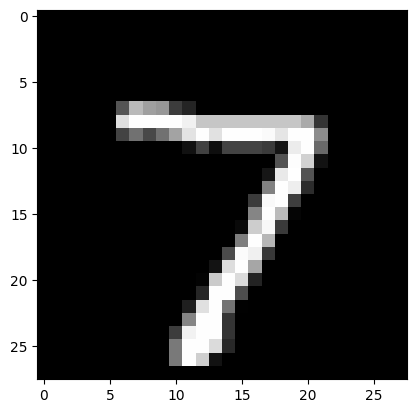

Predictive probabilities: [0.0850732  0.09608032 0.18916486 0.08185919 0.08372585 0.09675549
 0.10852771 0.07181123 0.11315582 0.07384635]
Out of distribution score: [0.98035306]


In [11]:
plt.imshow(X_ood[0:1].reshape(28,28), cmap="gray")
plt.show()
print('Predictive probabilities: {}'.format(scipy.special.softmax(model_GP(X_ood[0:1]).detach().numpy(), axis=1)[0]))
print('Out of distribution score: {}'.format(model_GP.predict(X_ood[0:1]).ood_scores.detach().numpy()))

### 4. Wrap embedding model with EquineProtonet

Our second wrapper replaces the softmax output of the original model with a protonet.

In [12]:
model_Proto = eq.equine_protonet.EquineProtonet(EmbeddingModel(model_orig.conv1.weight, 
                                  model_orig.conv2.weight, 
                                  model_orig.fc1.weight, 
                                  model_orig.fc2.weight), 
                        emb_out_dim=10, cov_type=eq.CovType.DIAGONAL, use_temperature=True, relative_mahal=False,
                        label_names=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"] )

To adapt to the new output, we fine tune the last layer.

In [13]:
res_Proto = model_Proto.train_model(TensorDataset(X_train, Y_train), num_episodes=3000, 
                        support_size=10, 
                        way=10, 
                        episode_size=1000)

100%|██████████████████████████████████████████████████████████| 3000/3000 [06:05<00:00,  8.22it/s]


We now compute the test accuracy and out of distribution results to compare with the original model.

Model accuracy on test set: 0.860


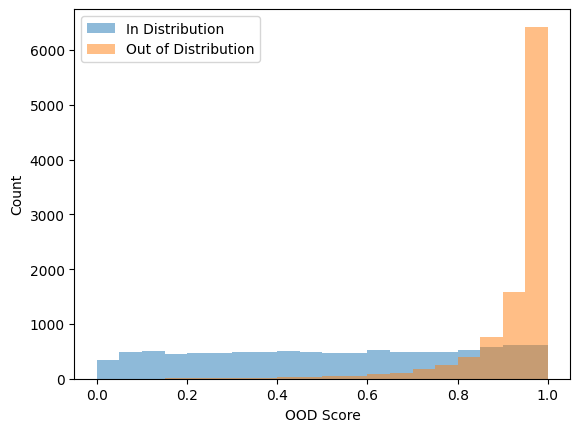

AUROC for detecting out of distribution examples: 0.922


In [14]:
oods_out_dist = model_Proto.predict(X_ood).ood_scores
oods_out_dist = oods_out_dist.detach().numpy()
oods_in_dist = model_Proto.predict(X_test).ood_scores
oods_in_dist = oods_in_dist.detach().numpy()

predictions = np.argmax(model_Proto.predict(X_test).classes.detach().numpy(), axis=1)
print('Model accuracy on test set: {0:.3f}'.format(np.mean(predictions == Y_test.detach().numpy())))

plt.hist(oods_in_dist,bins=np.linspace(0,1,21),alpha=0.5, label='In Distribution')
plt.hist(oods_out_dist,bins=np.linspace(0,1,21),alpha=0.5, label='Out of Distribution')
plt.xlabel('OOD Score')
plt.ylabel('Count')
plt.legend()
plt.show()

roc = roc_auc_score(np.hstack((np.ones_like(oods_out_dist),np.zeros_like(oods_in_dist))),
              list(oods_out_dist)+list(oods_in_dist))
print('AUROC for detecting out of distribution examples: {0:.3f}'.format(roc))

The protonet also does a good job of separating in distribution and out of distribution data, though its accuracy is lower than the original model for the Gaussian Process model.  The OOD score produced by the protonet is based on the distance to a representation of the closest class, rather than on the entropy of predictive probabilities.  One minus the OOD score of a particular example can be interpreted as the probability of observing an in distribution example that is further from its closest class representation than the example point.  As a result, the ood scores for the in distribution data roughly follow a uniform distribution.

Below, we see that the out out of distribution example receives a high OOD score.

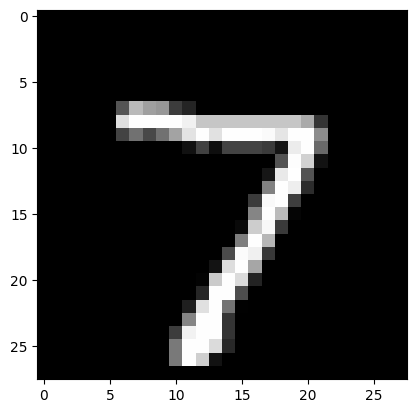

Out of distribution score:
[0.9787761]


In [15]:
plt.imshow(X_ood[0:1].reshape(28,28), cmap="gray")
plt.show()
print('Out of distribution score:')
print(model_Proto.predict(X_ood[0:1]).ood_scores.detach().numpy())

In [16]:
# Save out the GP and Protonet models for visualization in the web-app
model_GP.save("vis_FashionMNIST_GP.eq")
model_Proto.save("vis_FashionMNIST_protonet.eq")

In [17]:
# Save out some randomized datasets to load into the web-app
idxs = torch.randperm(X_test.size(0))[:50]
some_fashion_x = X_test[idxs]
some_fashion_y = Y_test[idxs]
torch.save(TensorDataset(some_fashion_x, some_fashion_y), "some_fashion_mnist_test_data.pt")

idxs = torch.randperm(X_ood.size(0))[:50]
some_digits_x = X_ood[idxs]
some_digits_y = X_ood[idxs]
torch.save(TensorDataset(some_digits_x, some_digits_y), "some_digits_mnist_test_data.pt")
